In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy
rectangular_ = 1
elliptic_ = 2

In [2]:
eSpread = 0
emitGeomRMS = 3.3e-6
npt = 3200*1000
nturn = 128
CLcut = 2.8

In [3]:
NL_L = 1.8
NL_c = 0.01
NL_t = 0.4
NL_nu = 0.3

betx = NL_L/np.sin(2.0*np.pi*NL_nu)
alfx = np.tan(np.pi*NL_nu)

# read Aperture

In [4]:
aperture = np.loadtxt('pipeinfo.in')

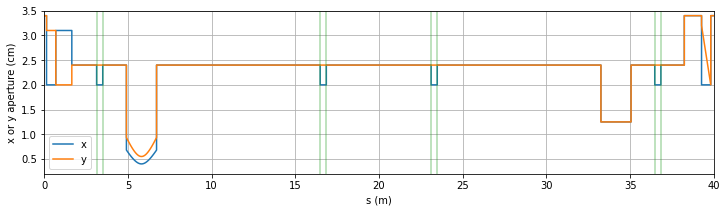

In [5]:
plt.figure(figsize=(12,3))
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.plot(aperture[:,0],(aperture[:,3]-1)*10,alpha=0.4)
plt.grid()
plt.ylim((0.2,3.5))
plt.xlim((0.0, 40))
plt.legend(('x','y'))
plt.xlabel('s (m)')
plt.ylabel('x or y aperture (cm)');

In [6]:
aperture[-1,0]

39.968229720000004

# read impact lattice

In [7]:
beam,lattice = impact.readInputFile('test.Chad.in')
beam.nCore_y=8
beam.nCore_z=4
beam.n_particles = npt

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

g = ke/mass+1.0
bg = np.sqrt(g**2-1.0)
emitN = emitGeomRMS*bg
print('\n\n emitN =',emitN)

reading ImpactZ input file (test.Chad.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


 emitN = 2.4105916749973357e-07


In [8]:
cleanLat = impact.clearLattice(lattice)
L = 0 
for item in cleanLat:
    if item.type == 'RFkick':
        item.vmax = 0.0
    if item.type == 'nonlinear_insert':
        print('NL:',L,L+item.length)
    if 'length' in item:
        L = L+item.length
print(L-aperture[-1,0])

NL: 4.9115191429 6.711519142899999
-4.199918635094946e-09


In [9]:
for item in cleanLat:
    if 'length' in item:
        item.n_sckick = int(np.ceil(item.length*50))
        item.n_map = 1

# Back tracking for IOTA matched beam at injection location

In [10]:
for i in range(len(cleanLat)):
    if cleanLat[i].type == 'nonlinear_insert':
        break

latticeB = impact.getInverseLattice(cleanLat[:i])

In [11]:
write0 = impact.getElem('write_raw_ptcl')
write0.file_id = 111110
write0.format_id = 2
latticeB.insert(0,write0)


write1 = impact.getElem('write_raw_ptcl')
write1.file_id = 111111
write1.format_id = 2
latticeB.append(write1)

In [12]:
loop = impact.getElem('loop')
loop.turns = 1
latticeB.insert(0,loop)

In [13]:
beam.distribution.distribution_type = 'IOTA_Gauss'
beam.distribution.NL_t  = NL_t
beam.distribution.NL_c  = NL_c
beam.distribution.betx  = betx
beam.distribution.alfx  = alfx
beam.distribution.emitx = emitGeomRMS
beam.distribution.CL    = CLcut
beam.distribution.betz  = 200
beam.distribution.alfz  = 0.0
beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz

# beam.distribution.distribution_type = 'Gauss'
# beam.distribution.alfx = alfx
# beam.distribution.betx = betx
# beam.distribution.alfy = alfx
# beam.distribution.bety = betx
# beam.distribution.emitx = emitN
# beam.distribution.emity = emitN
# beam.distribution.betz  = 200
# beam.distribution.alfz  = 0.0
# beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz

betx,alfx,emitGeomRMS,beam.distribution.emitz

(1.8926320036288808, 1.3763819204711734, 3.3e-06, 0.0)

In [14]:
impact.writeInputFile(beam,latticeB)
impact.run(beam)

0

In [15]:
pData0 = impact.readParticleData(111110,ke,mass,freq,2)

In [16]:
impact.getTwiss_from_pData(pData0)

/users/kilean/IOTA/pImpactR/pImpactR/impactIO.py:1539: RuntimeWarning: invalid value encountered in double_scalars
  betz = varx/emitz
/users/kilean/IOTA/pImpactR/pImpactR/impactIO.py:1540: RuntimeWarning: invalid value encountered in double_scalars
  alfz = np.sqrt(varpx/emitz*betz-1)


(1.4786389411436967,
 1.0763075625804996,
 1.8362994028310194e-06,
 3.3792660849612077,
 2.457430001855717,
 4.193354466037064e-06,
 nan,
 nan,
 0.0)

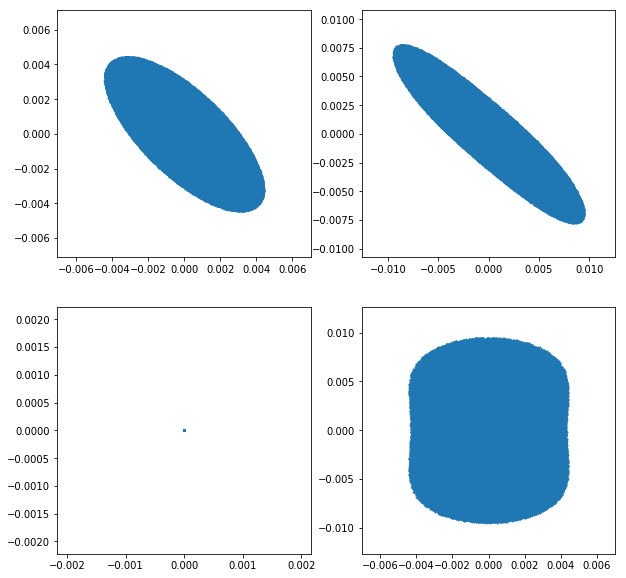

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(pData0[:,0],pData0[:,1],s=1.0)
plt.subplot(2,2,2)
plt.scatter(pData0[:,2],pData0[:,3],s=1.0)
plt.subplot(2,2,3)
plt.scatter(pData0[:,4],pData0[:,5],s=1.0)
plt.subplot(2,2,4)
plt.scatter(pData0[:,0],pData0[:,2],s=1.0)

In [18]:
pData1 = impact.readParticleData(111111,ke,mass,freq,2)

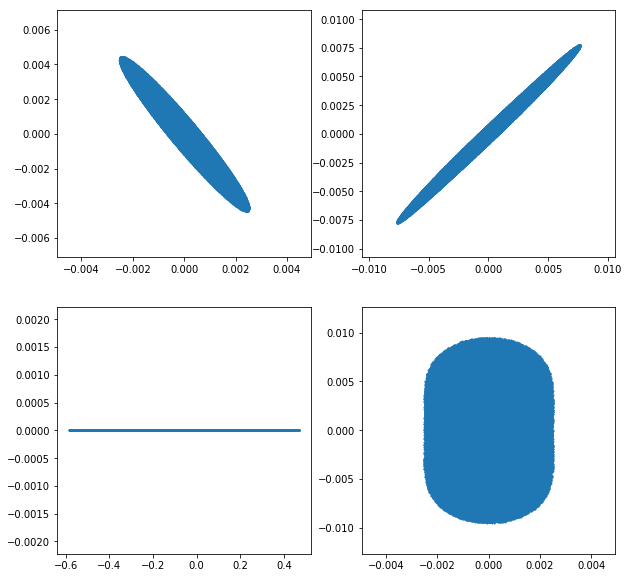

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(pData1[:,0],pData0[:,1],s=1.0)
plt.subplot(2,2,2)
plt.scatter(pData1[:,2],pData0[:,3],s=1.0)
plt.subplot(2,2,3)
plt.scatter(pData1[:,4],pData0[:,5],s=1.0)
plt.subplot(2,2,4)
plt.scatter(pData1[:,0],pData0[:,2],s=1.0)

In [20]:
impact.getTwiss_from_pData(pData1)

/users/kilean/IOTA/pImpactR/pImpactR/impactIO.py:1539: RuntimeWarning: divide by zero encountered in double_scalars
  betz = varx/emitz
/users/kilean/IOTA/pImpactR/pImpactR/impactIO.py:1540: RuntimeWarning: invalid value encountered in double_scalars
  alfz = np.sqrt(varpx/emitz*betz-1)


(0.4792372034123979,
 0.1766205668337573,
 1.836298350120734e-06,
 2.096781608091311,
 0.5089984790853281,
 4.193350922629994e-06,
 inf,
 nan,
 0.0)

# run

In [21]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 111111

In [22]:
# beam.distribution.alfx = 3.860846841e-5
# beam.distribution.betx = 0.561065822
# beam.distribution.alfy = 2.282987698e-9
# beam.distribution.bety = 1.385141718
# beam.distribution.emitx = emitN
# beam.distribution.emity = emitN
# beam.distribution.betz  = 200
# beam.distribution.alfz  = 0.0
# beam.distribution.emitz = (eSpread*ke*1.0e-6)**2*beam.distribution.betz
# beam.distribution.distribution_type = 'IOTA_Gauss'

# run Impact

In [23]:
cleanLat.insert(0,impact.getElem('pipeinfo'))
cleanLat.insert(1,impact.getElem('loop'))
cleanLat[1].turns = nturn

In [24]:
writeP = impact.getElem('write_raw_ptcl')
writeP.file_id = 3456
writeP.format_id = 2
cleanLat.insert(2,writeP)

In [25]:
impact.writeInputFile(beam,cleanLat)
impact.run(beam)

0

In [26]:
pData = impact.readParticleData(3456,ke,mass,freq,2)

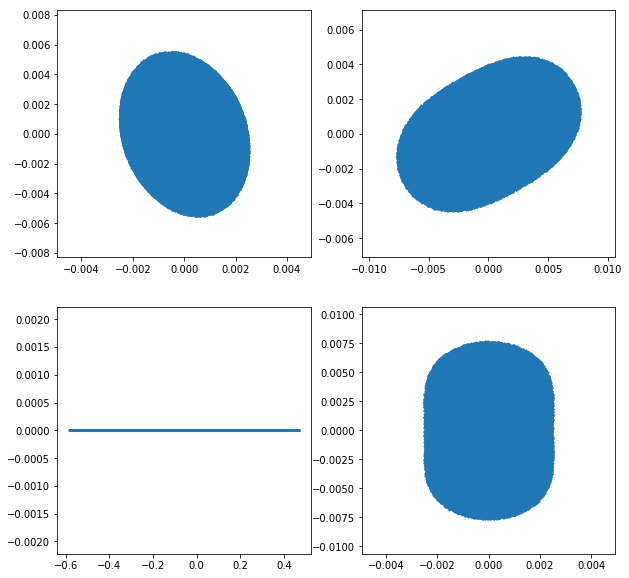

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(pData[:,0],pData[:,1],s=1.0)
plt.subplot(2,2,2)
plt.scatter(pData[:,2],pData[:,3],s=1.0)
plt.subplot(2,2,3)
plt.scatter(pData[:,4],pData[:,5],s=1.0)
plt.subplot(2,2,4)
plt.scatter(pData[:,0],pData[:,2],s=1.0)

In [28]:
np.std(pData[:,5]/ke)

0.0

In [29]:
lostp = np.loadtxt('lost_partcl.data',skiprows=1, usecols=(0,1,2,4))

In [30]:
lostp.shape

(13377, 4)

In [31]:
np.save('lost_partcl.IOTA_gauss.cut'+str(CLcut)+'.I=0.NLon.noEspread.npy',lostp)

In [32]:
lostp = np.load('lost_partcl.IOTA_gauss.cut'+str(CLcut)+'.I=0.NLon.noEspread.npy')

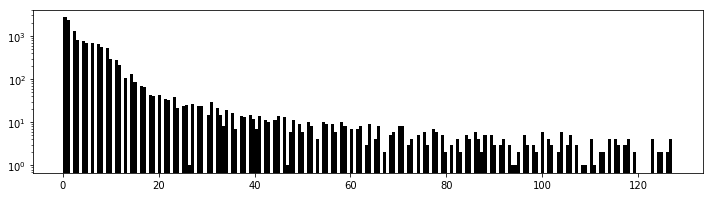

In [33]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0]/L,bins=200,color='k');
plt.yscale('log')

In [34]:
lostp[:,0] = np.mod(lostp[:,0],L)
lostp.shape

(13377, 4)

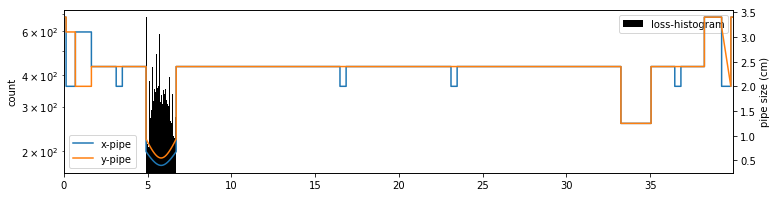

In [35]:
plt.figure(figsize=(12,3))
plt.hist(lostp[:,0],bins=40,color='k');
plt.xlim(0,L)
plt.yscale('log')
plt.ylabel('count')
plt.legend(['loss-histogram'])
plt.twinx()
plt.plot(aperture[:,0],aperture[:,1]*100)
plt.plot(aperture[:,0],aperture[:,2]*100)
plt.ylabel('pipe size (cm)')
plt.legend(['x-pipe','y-pipe'])

(-0.012, 0.012)

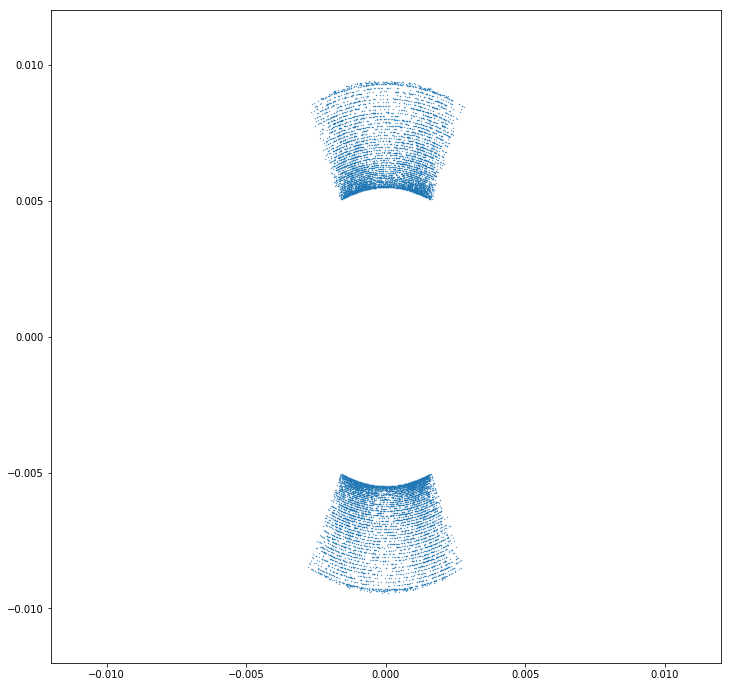

In [36]:
plt.figure(figsize=(12,12))
plt.scatter(lostp[:,1],lostp[:,2],s=0.1)
plt.xlim(-0.012,0.012)
plt.ylim(-0.012,0.012)